In [48]:
%cd ..
%load_ext autoreload
%autoreload 2

REMOTE_RTS_DATA = "/media/sinergia/RTS/"
REMOTE_VIDEOS = '/mnt/rts/'

LOCAL_RTS_DATA = "/media/data/rts/"
METADATA = LOCAL_RTS_DATA + 'metadata'
LOCAL_VIDEOS = LOCAL_RTS_DATA + 'archive/'

AIBOX = LOCAL_RTS_DATA + 'aibox-vectors'

OUTDIR = 'data'

/home/andre
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from datetime import datetime
import orjson
import pandas as pd
import zipfile
import os
import io
from typing import Dict, List, Optional, Tuple
from pathlib import Path
import json

In [3]:
# LOCAL imports
import emv
import emv.utils
import emv.io.media


LOG = emv.utils.get_logger()

In [4]:
df = emv.utils.dataframe_from_hdf5(LOCAL_RTS_DATA + '/metadata', 'rts_aivectors')

In [5]:
with open("/home/andre/rts/data/rts_sports_categories_umap.json", "r") as f:
    data = json.load(f)

In [6]:
df_emb = pd.DataFrame(data['embedding'])
df_emb.head()

,id_result,umid,path,sport,scenes_tc,embedding_coord
0,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[0, 15]","[0.42291563749313354, 0.7124888300895691, 0.99..."
1,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[16, 31]","[0.42267531156539917, 0.7122476100921631, 0.99..."
2,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[32, 47]","[0.42248374223709106, 0.7122003436088562, 0.99..."
3,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[48, 63]","[0.4229308068752289, 0.7124335765838623, 0.998..."
4,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[64, 79]","[0.42289605736732483, 0.712624192237854, 0.997..."


In [7]:

df_emb[df_emb.umid == "ZB005015"]

,id_result,umid,path,sport,scenes_tc,embedding_coord
0,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[0, 15]","[0.42291563749313354, 0.7124888300895691, 0.99..."
1,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[16, 31]","[0.42267531156539917, 0.7122476100921631, 0.99..."
2,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[32, 47]","[0.42248374223709106, 0.7122003436088562, 0.99..."
3,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[48, 63]","[0.4229308068752289, 0.7124335765838623, 0.998..."
4,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[64, 79]","[0.42289605736732483, 0.712624192237854, 0.997..."
...,...,...,...,...,...,...
396,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[3184, 3193]","[0.3959805369377136, 0.5536730289459229, 0.362..."
397,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[3194, 3197]","[0.42643970251083374, 0.5627828240394592, 0.36..."
398,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[3198, 3198]","[0.3702424466609955, 0.6820469498634338, 0.408..."
399,47be596638b646dabcec3a7ba9510be8,ZB005015,R:/aibox-vectors/videos/8/e/b/47be596638b646da...,Résultats et magazines sportifs,"[3199, 3205]","[0.3725535571575165, 0.5709545016288757, 0.416..."


In [8]:
# Sanity check if we can find all videos

count = 0

for umid in df_emb.umid.unique():
    media_path = LOCAL_VIDEOS + "/" + df.loc[umid].mediaFolderPath.split("/mnt/rts/")[1] + "/" + umid + ".mp4"
    # print(media_path)
    if os.path.isfile(media_path):
        count += 1
count

427

In [9]:
df.loc['ZB005015']

guid                                                     GE0403178015
mediaFolderPath                               /mnt/rts/5/1/0/ZB005015
mediaDuration                                                    3103
ratio                                                             4:3
formatResolution                                                   SD
publishedDate                                    2004-04-04T00:00:00Z
categoryName                                                Programme
assetType                                                   Programme
contentType                           Résultats et magazines sportifs
backgoundType                                              [EMISSION]
collection                                             Dimanche Sport
publishedBy                                                     TSR 1
rights                                          Restriction/Condition
title                                                        04.04.04
resume              

In [10]:
def calculate_difference(row):
    return row['scenes_tc'][1] - row['scenes_tc'][0]

df_emb['difference'] = df_emb.apply(calculate_difference, axis=1)

<Axes: >

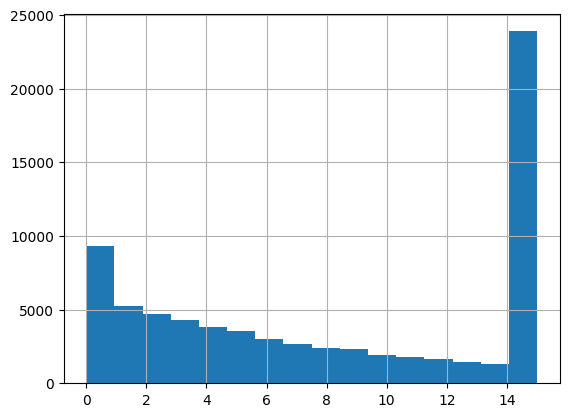

In [11]:
df_emb.difference.hist(bins=16)

In [12]:
from tqdm.notebook import trange, tqdm

In [64]:
import ffmpeg
from io import BytesIO
from typing import Union, List, Tuple
from pathlib import Path




def get_frame_rate(input_path: Union[str, Path]) -> float:
    probe = ffmpeg.probe(str(input_path))
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream is None:
        return None
    
    r_frame_rate = video_stream['r_frame_rate']
    num, den = map(int, r_frame_rate.split('/'))
    return num / den


def get_number_of_frames(input_path: Union[str, Path]) -> int:
    probe = ffmpeg.probe(str(input_path))
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream is None:
        return None
    
    return int(video_stream['nb_frames'])


In [65]:

def trim(input_path: Union[str, Path], timestamps: List[Tuple[float, float]]) -> List[BytesIO]:
    buffers = []
    try:
        # frame_rate = get_frame_rate(input_path)
        # number_of_frames = get_number_of_frames(input_path)
        
        # print(f"Frame rate: {frame_rate} frames per second")
        # print(f"Total number of frames: {number_of_frames}")

        for start_ts, end_ts in tqdm(timestamps):
            # start = datetime.now()
            out, _ = (
                ffmpeg
                .input(str(input_path), ss=start_ts)
                .output(
                    "pipe:1", 
                    format='mp4', 
                    vcodec='libx264', 
                    acodec='aac', 
                    ab='128k',
                    t=end_ts - start_ts,
                    strict='experimental', 
                    movflags='faststart+frag_keyframe+empty_moov'
                )
                .run(capture_stdout=True, capture_stderr=True)
            )
            # end = datetime.now()
            # print(f'FFmpeg took {(end - start).total_seconds()} seconds to trim {i + 1} of {len(timestamps)}')
            
            buffers.append(BytesIO(out))

    except ffmpeg.Error as e:
        print(f'FFmpeg Error: {e.stderr.decode()}')
    
    return buffers

In [99]:
from emv.db.dao import DataAccessObject
from emv.settings import DATABASE_URL
from emv.db.queries import get_library_id_from_name, get_media_by_id
from emv.io.media import upload_media_files
from emv.api.models import Media
import os
import hashlib
from emv.settings import BUCKET_NAME
from emv.db.queries import create_atlas, create_media, create_projection, read_media
from emv.storage.storage import get_storage_client
from emv.api.models import Atlas, Media, Projection
import pandas as pd
from dotenv import load_dotenv

from sqlalchemy.exc import IntegrityError
import logging

logging.basicConfig(level=logging.INFO)

load_dotenv()
DataAccessObject().connect(DATABASE_URL)

In [61]:
# Setup before we can create media objects
archive_name =  "rts"
bucket_name =  archive_name
library_id =  get_library_id_from_name(archive_name)
library_id

1

In [79]:

def trim(input_path: Union[str, Path], start_ts: int, end_ts: int) -> BytesIO:
    try:
        out, _ = (
            ffmpeg
            .input(str(input_path), ss=start_ts)
            .output(
                "pipe:1", 
                format='mp4', 
                vcodec='libx264', 
                acodec='aac', 
                ab='128k',
                t=end_ts - start_ts,
                strict='experimental', 
                movflags='faststart+frag_keyframe+empty_moov'
            )
            .run(capture_stdout=True, capture_stderr=True)
        )
        
    except ffmpeg.Error as e:
        print(f'FFmpeg Error: {e.stderr.decode()}')
    
    return BytesIO(out)

In [75]:
frame_rates = {}
clips = {}
media_ids = {}

for i, row in df_emb.iterrows():

    media_id = row.umid + "GA" + str(i).zfill(5)
    original_path = os.path.join(df.loc[row.umid].mediaFolderPath.replace(REMOTE_VIDEOS, LOCAL_VIDEOS), f"{row.umid}.mp4")
    media_path = f"videos/{row.umid}/{media_id}.mp4"
    
    if frame_rates.get(original_path) is None:
        frame_rates[original_path] = get_frame_rate(original_path)

    metadata = {
        'sport': row.sport,
        'collection': df.loc[row.umid].collection,
        'published_by': df.loc[row.umid].publishedBy,
        'published_date': df.loc[row.umid].publishedDate,
    }

    media_ids[media_id] = row
    
    clips[media_id] = Media(**{
        'media_id': media_id,
        'original_path': original_path,
        'original_id': row.umid,
        'media_path': media_path, 
        'media_type': "video",
        'sub_type': "clip", 
        'size': -1, # write size later when we process the clips 
        'metadata': metadata,
        'library_id': library_id, 
        'hash': hashlib.md5(media_path.encode()).hexdigest(), 
        'parent_id': -1,
        'start_ts': row.scenes_tc[0], 'end_ts': row.scenes_tc[0], 
        'start_frame': row.scenes_tc[0] * frame_rates[original_path], 'end_frame': row.scenes_tc[0] * frame_rates[original_path], 'frame_rate': frame_rates[original_path], 
    })

In [102]:
for key in tqdm(media_ids):
    # print(key, media_ids[key].scenes_tc[0], media_ids[key].scenes_tc[1])
    # print(clips[key].dict())

    if media_ids[key].scenes_tc[1] - media_ids[key].scenes_tc[0] < 4:
        continue

    try:
        create_media(clips[key])

        buffer = trim(clips[key].original_path, media_ids[key].scenes_tc[0], media_ids[key].scenes_tc[1])
        clips[key].size = len(buffer.getvalue())
        get_storage_client().upload_binary(bucket_name, clips[key].media_path, buffer)
    except IntegrityError as e:
        if "duplicate key value violates unique constraint" in str(e):
            pass
            # logging.info(f'UniqueViolation: Duplicate media_id {clips[key].media_id}')
        else:
            raise e


  0%|          | 0/73402 [00:00<?, ?it/s]

INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00000
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00001
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00002
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00003
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00004
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00006
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00009
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00011
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00014
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00015
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00018
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00019
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00021
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00022
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00024
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00025
INFO:roo

INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00088
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00090
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00091
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00093
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00095
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00098
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00101
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00103
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00104
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00106
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00107
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00108
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00109
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00111
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00112
INFO:root:UniqueViolation: Duplicate media_id ZB005015GA00113
INFO:roo

KeyboardInterrupt: 

In [66]:
# timestamps = [(x[0], x[1]) for x in df_emb[df_emb.umid == "ZB005015"].scenes_tc.values if x[1] - x[0] > 4][:10]
# buffers = trim('/media/data/rts/archive/5/1/0/ZB005015/ZB005015.mp4', timestamps)

Frame rate: 25.0 frames per second
Total number of frames: 80619


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def upload_media(media: Media, data: BytesIO, bucket_name: str = BUCKET_NAME) -> Dict:
    get_storage_client().upload_binary(bucket_name,
                                media.media_path, data)

    return create_media(media)


def upload_media_files(media_files: List[Media], bucket_name: str = BUCKET_NAME) -> List[Dict]:
    uploaded_clips = []

    for mf in media_files:
        uploaded_clips.append(upload_media(
            media=mf,
            bucket_name=bucket_name,
        ))
    return uploaded_clips

In [150]:
# with open('output1.mp4', 'wb') as f:
#     f.write(buffers[0].getvalue())
# with open('output2.mp4', 'wb') as f:
#     f.write(buffers[1].getvalue())

In [67]:
import ffmpeg

def has_variable_frame_rate(input_path: str) -> bool:
    try:
        # Get the frame rate for each frame
        result = (
            ffmpeg
            .input(input_path)
            .filter('vfrdet')
            .output('-', format='null')
            .run(capture_stdout=True, capture_stderr=True)
        )
        
        # Analyze the output to see if vfr was detected
        stderr_output = result[1].decode()
        vfr_line = next(line for line in stderr_output.split('\n') if 'VFR:' in line)
        is_vfr = 'VFR:1' in vfr_line

        return is_vfr

    except ffmpeg.Error as e:
        print(f'FFmpeg Error: {e.stderr.decode()}')
        return None

# Example usage:
video_path = '/media/data/rts/archive/5/1/0/ZB005015/ZB005015.mp4'
print(f"Video has variable frame rate: {has_variable_frame_rate(video_path)}")


Video has variable frame rate: False
